## LIME 적용하기 (이미지 데이터)
- Scikit-learn 패키지의 fetch_olivetti_faces 데이터 사용
- Datasets
    - 40명의 얼굴을 각각 10장씩 촬영
    - 각 이미지는 다른 시각에, 다른 빛의 방향, 다른 표정으로 촬영 됨
    - 총 400장, 각각의 이미지는 8bit 흑백, 64x64
    

## 1. import Library and Data Load

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray
from skimage.util import montage

from sklearn.datasets import fetch_olivetti_faces

# data
faces = fetch_olivetti_faces()
print(type(faces), faces.keys())

# img data 
print(faces.data.shape)

<class 'sklearn.utils.Bunch'> dict_keys(['data', 'images', 'target', 'DESCR'])
(400, 4096)


In [2]:
# 이미지 흑백으로 만들고 LIME이 처리할 수 있는 형태로 변환
X_vec = np.stack([gray2rgb(iimg) 
                 for iimg in faces.data.reshape(-1, 64, 64)], 0)
y_vec = faces.target.astype(np.uint8)

# X_img, y_vector (0 ~ 40)
print(X_vec.shape, y_vec.shape)

(400, 64, 64, 3) (400,)


(-0.5, 1279.5, 1279.5, -0.5)

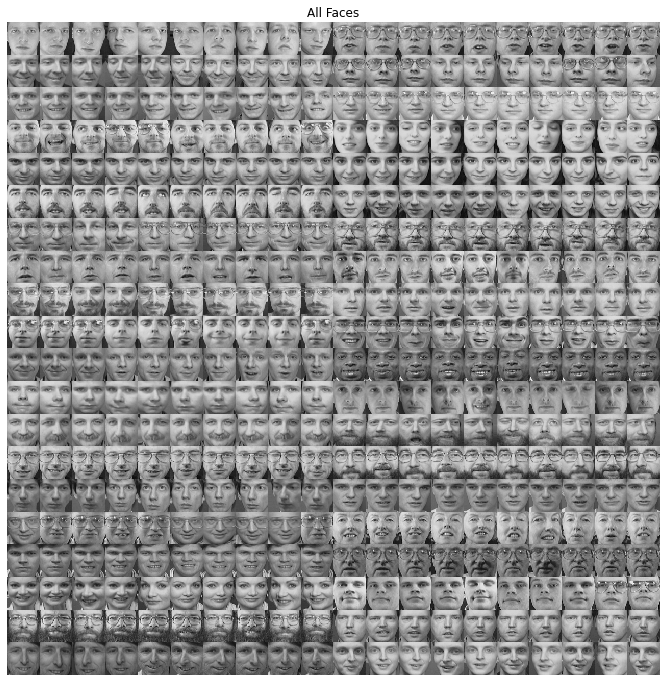

In [64]:
# All Faces 출력
fig, ax1 = plt.subplots(1, 1, figsize=(12,12))
ax1.imshow(montage(X_vec[:,:,:,0]),
          cmap = 'gray', interpolation = 'none')
ax1.set_title('All Faces')
ax1.axis('off')

(-0.5, 63.5, 63.5, -0.5)

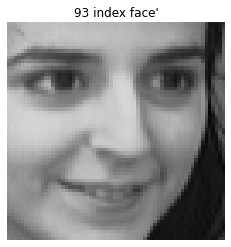

In [4]:
# 올리베티 얼굴 93번
index = 93
plt.imshow(X_vec[index], cmap='gray')
plt.title("{} index face'".format(index))
plt.axis("off")

## 2. 모델 학습하기
- Lime의 Explainer의 파라미터로는 (1) 설명이 필요한 데이터 1개, (2) 해당 데이터에 대한 분류 확률을 출력하는 모델이 필요
- (2) 의 경우 분류기 모델에서 제공하는 predict_proba 메서드가 필요 (기존 메서드 or 자체 제작 필요)
- MLP (Mluti-layer Perceptron Classifier) 사용

In [5]:

# Train data, Test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vec,
                                                   y_vec,
                                                   train_size = 0.7)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(280, 64, 64, 3) (120, 64, 64, 3) (280,) (120,)


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.neural_network import MLPClassifier

class PipeStep(object):
    def __init__(self, step_func):
        self._step_func = step_func
        
    def fit(self, *args):
        return self
    def transform(self, X):
        return self._step_func(X)
    
# Pipe Step - Preprocessing
# rgb to gray
makegray_step = PipeStep(lambda img_list: 
                                 [rgb2gray(img) for img in img_list])

# img to flatten (by ravel method - MLP가 1차원 배열)
flatten_step = PipeStep(lambda img_list:
                                [img.ravel() for img in img_list])

simple_pipeline = Pipeline([
    # Preprocessing
    ('Make Gray', makegray_step), 
    ('Flatten Image', flatten_step),
    ('Normalize', Normalizer()),
    
    # Modeling
    ('MLP', MLPClassifier(
        activation='relu',
        alpha=1e-7,
        epsilon=1e-6,
        hidden_layer_sizes=(800, 120), # 40명
        random_state = 1)
    )
])

simple_pipeline

Pipeline(memory=None,
         steps=[('Make Gray', <__main__.PipeStep object at 0x0000019555ACDE48>),
                ('Flatten Image',
                 <__main__.PipeStep object at 0x0000019555ACDE08>),
                ('Normalize', Normalizer(copy=True, norm='l2')),
                ('MLP',
                 MLPClassifier(activation='relu', alpha=1e-07,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-06,
                               hidden_layer_sizes=(800, 120),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=200, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=1, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
               

In [11]:
# 학습
simple_pipeline.fit(X_train, y_train)

c:\users\urse\anaconda3\envs\untitled\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
         steps=[('Make Gray', <__main__.PipeStep object at 0x0000019555ACDE48>),
                ('Flatten Image',
                 <__main__.PipeStep object at 0x0000019555ACDE08>),
                ('Normalize', Normalizer(copy=True, norm='l2')),
                ('MLP',
                 MLPClassifier(activation='relu', alpha=1e-07,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-06,
                               hidden_layer_sizes=(800, 120),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=200, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=1, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
               

In [12]:
# def predict_proba(image):
#     return model.predict(image)

# 분류 결과 출력
pipe_pred_test = simple_pipeline.predict(X_test)
print(pipe_pred_test)

# 분류 확률 출력
pipe_pred_prop = simple_pipeline.predict_proba(X_test)
print(pipe_pred_prop)


[39  1 14  2 17 24  8  7 24 35 16 31 23 29 35 35 16 10 23 13 21 29 36 15
 15  5 20 38 28 19 15 13 39 34 16  2 30 21 39 15 36 32 20 25 12 37 37 13
  1  3  7 22 11 18 14 25 39 31 36 28  4  5 16  9  3 14 24  9 37  0 14 21
 17 30  7  6 12 18 12 10 26 23 28  4 19 19 16  8  6 29  5  5 22 11 27 39
  6  7  7 28  3 34 16 14 25 33 32 37 28 13 28 38 29  4 34 26 18 12  4  2]
[[4.40108274e-02 3.37792825e-10 9.24195002e-04 ... 2.29218456e-04
  2.95713217e-06 7.65175432e-01]
 [5.24717148e-05 9.77385145e-01 2.78217022e-10 ... 1.19654875e-12
  4.49336495e-09 1.64726203e-10]
 [7.24520038e-06 1.13573449e-03 3.98441412e-08 ... 1.05858740e-08
  3.39719097e-03 1.09841464e-07]
 ...
 [3.79522826e-04 9.31133257e-09 1.01340001e-03 ... 4.14090196e-06
  2.78125866e-05 1.69497990e-03]
 [4.60331883e-06 2.84810234e-11 9.38613531e-06 ... 2.06555396e-04
  9.58732790e-04 1.79620281e-03]
 [7.22362877e-04 7.39882935e-12 3.13801647e-01 ... 2.55296238e-01
  6.82482834e-03 1.22669290e-02]]


In [13]:
# 테스트 데이터셋의 예측 결과와(pipe_pred_prop) 실제 테스트 레이블(y_test) 비교
from sklearn.metrics import classification_report
print(classification_report(y_true = y_test, y_pred = pipe_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           2       0.33      1.00      0.50         1
           3       0.67      0.50      0.57         4
           4       1.00      1.00      1.00         4
           5       0.75      1.00      0.86         3
           6       1.00      0.75      0.86         4
           7       1.00      0.83      0.91         6
           8       0.50      1.00      0.67         1
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       0.50      0.50      0.50         4
          13       1.00      1.00      1.00         4
          14       0.80      1.00      0.89         4
          15       0.75      0.75      0.75         4
          16       0.67      0.57      0.62         7
          17       1.00    

<hr>

## LIME을 이용한 분석
- MLP 모델은 인물을 어떻게 해석하는지 확인
- 비교적 성능이 낮은 12번(0.5), 비교적 성능이 높은 21번(1.0) 분석

- 설명 모델
    - Model regressor로 설명
- 서브 모듈 이미지 분할 알고리즘
    - segmentationAlgorithm 정의 

In [35]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

# lime 설명 모델
explainer = lime_image.LimeImageExplainer()

# 이미지 분할 알고리즘 : quickshift(기본), slic(슬릭), felzenszwalb(펜젠스왈브)
# 이미지 100개로 분할
segmenter = SegmentationAlgorithm('slic', 
                                  n_segments=100, # 이미지 분할 조각 갯수
                                  compactness=1,# 로그스케일 분할한 이미지 조각으로부터 유사한 파트 합치는 것
                                  sigma=1 # 분할 이미지 smoothing
                            )
print(explainer)
print(segmenter)


## 학습 결과가 잘 된 경우

In [44]:
%%time
olivetti_test_index = 21 # test_index

# 설명 모델 정의, segmenter 활용
exp = explainer.explain_instance(X_test[olivetti_test_index], 
                                classifier_fn = simple_pipeline.predict_proba,
                                top_labels=6, # 모델이 예측하는 1등~6등 분석
                                num_samples=1000, # 결정경계를 위한 공간의 크기
                                segmentation_fn = segmenter 
                                )
exp

c:\users\urse\anaconda3\envs\untitled\lib\site-packages\lime\wrappers\scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)



Wall time: 1.13 s


Text(0.5, 1.0, 'Show mask only')

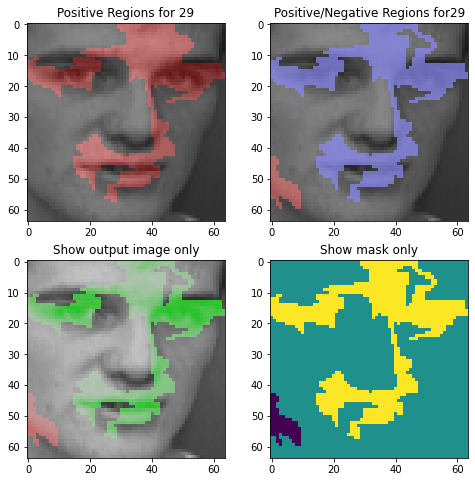

In [45]:
from skimage.color import label2rgb

# 캔버스 설정
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))

# 설명 모델이 가장 높다고 생각하는 라벨 (사람)의 
# 예측의 도움이 되는 이미지 세그먼트들 출력
temp, mask = exp.get_image_and_mask(y_test[olivetti_test_index], # 이미지 원본
                                    positive_only = True, # 라벨에 도움이 되는 이미지 or 모든 세그먼트 출력
                                    num_features=8, # 분할 영역의 크기
                                    hide_rest=False) # XAI에 도움이 되는 영역만 출력 옵션

ax1.imshow(label2rgb(mask, temp, bg_label=0),
          interpolation='nearest')

ax1.set_title('Positive Regions for {}'.format(y_test[olivetti_test_index]))


# 모든 세그먼트 출력하기
temp, mask = exp.get_image_and_mask(y_test[olivetti_test_index],
                                    positive_only = False,
                                    num_features=8,
                                    hide_rest = False)

ax2.imshow(label2rgb(mask, temp, bg_label=0),
          interpolation='nearest')
ax2.set_title('Positive/Negative Regions for{}'.format(y_test[olivetti_test_index]))

# 이미지만 출력
ax3.imshow(temp, interpolation= 'nearest')
ax3.set_title('Show output image only')

# 마스크만 출력
ax4.imshow(mask, interpolation='nearest')
ax4.set_title('Show mask only')

## XAI 해석
- 1번째 이미지 : 설명 모델이 가장 높은 확률로 분류한 라벨에 도움이 되는 이미지 영역 (상위 몇개)
- 2번째 이미지 : 모든 이미지 조각 마스킹 레이블 (색이 다르면 다른 라벨도 기여한 것)
- 3번쨰 이미지 : 설명 모델이 유용하게 사용한 이미지 조각
- 
- 눈이나 콧매, 입, 미간등이 해당 

## 학습 결과가 잘 안 된 경우

In [61]:
%%time
olivetti_test_index = 12 # test_index

# 설명 모델 정의, segmenter 활용
exp = explainer.explain_instance(X_test[olivetti_test_index], 
                                classifier_fn = simple_pipeline.predict_proba,
                                top_labels=6, # 1등~6등 분석
                                num_samples=1000,
                                segmentation_fn = segmenter 
                                )
exp

c:\users\urse\anaconda3\envs\untitled\lib\site-packages\lime\wrappers\scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)



Wall time: 1.19 s


Text(0.5, 1.0, 'Show mask only')

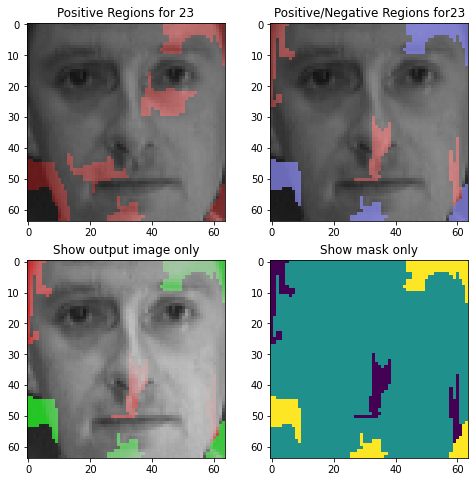

In [62]:
from skimage.color import label2rgb

# 캔버스 설정
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))

# 설명 모델이 가장 높다고 생각하는 라벨 (사람)의 
# 예측의 도움이 되는 이미지 세그먼트들 출력
temp, mask = exp.get_image_and_mask(y_test[olivetti_test_index], # 이미지 원본
                                    positive_only = True, # 라벨에 도움이 되는 이미지 or 모든 세그먼트 출력
                                    num_features=8, # 분할 영역의 크기
                                    hide_rest=False) # XAI에 도움이 되는 영역만 출력 옵션

ax1.imshow(label2rgb(mask, temp, bg_label=0),
          interpolation='nearest')

ax1.set_title('Positive Regions for {}'.format(y_test[olivetti_test_index]))


# 모든 세그먼트 출력하기
temp, mask = exp.get_image_and_mask(y_test[olivetti_test_index],
                                    positive_only = False,
                                    num_features=8,
                                    hide_rest = False)

ax2.imshow(label2rgb(mask, temp, bg_label=0),
          interpolation='nearest')
ax2.set_title('Positive/Negative Regions for{}'.format(y_test[olivetti_test_index]))

# 이미지만 출력
ax3.imshow(temp, interpolation= 'nearest')
ax3.set_title('Show output image only')

# 마스크만 출력
ax4.imshow(mask, interpolation='nearest')
ax4.set_title('Show mask only')

## XAI 해석
- 특징점을 잘 못찾거나, 학습데이터의 인물사진간 비슷한 점이 많거나
- 인물이 구별이 더 잘되는 각도나 빛의 방향을 더 찾아서 학습